In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
display.set_matplotlib_formats("svg")

C:\Users\Admin\AppData\Local\Temp\ipykernel_11164\2164488982.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [11]:
# a function that creates data

def createSomeData(nPerClust):
    
    A = [ 1, 1 ]
    B = [ 5, 1 ]
    C = [ 4, 4 ]
    
    # generate data
    a = [ A[0] + np.random.randn(nPerClust), A[1] + np.random.randn(nPerClust)]
    b = [ B[0] + np.random.randn(nPerClust), B[1] + np.random.randn(nPerClust)]
    c = [ C[0] + np.random.randn(nPerClust), C[1] + np.random.randn(nPerClust)]
    
    # true labels
    labels_np = np.hstack((np.zeros((nPerClust)), np.ones((nPerClust)), 1 + np.ones((nPerClust))))
    
    # concatenate into a matrix
    data_np = np.hstack((a, b, c)).T
    
    # put all outputs into a dictionary
    output = {}
    output["data"] = torch.tensor(data_np).float()
    output["labels"] = torch.tensor(labels_np).long() # long formats integers

    # use scikitlearn to split the data
    train_data, test_data, train_labels, test_labels = train_test_split(output["data"], output["labels"], test_size = .9)

    # then convert them into PyTorch Datasets (note: already converted to tensors)
    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)

    # finally, translate into dataloader objects
    batchsize = 8
    output["train_data"] = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last = True)
    output["test_data"] = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])
    
    return output

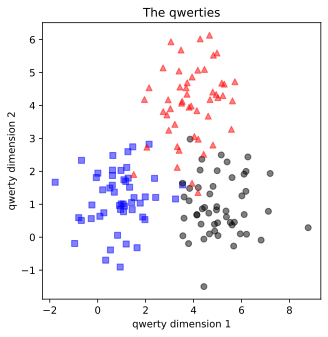

In [12]:
# check that the function works

theData = createSomeData(50)

data = theData["data"]
labels = theData["labels"]

# show the data
fig = plt.figure(figsize = (5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], "bs", alpha = .5)
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], "ko", alpha = .5)
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], "r^", alpha = .5)
plt.title("The qwerties")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

In [13]:
# create a class for the model
def createTheQwertyNet(nUnits, nLayers):
    class qwertyNet(nn.Module):
        def __init__(self, nUnits, nLayers):
            super().__init__()

            # create a dictionary
            self.layers = nn.ModuleDict()
            self.nLayers = nLayers
            
            # input layer
            self.layers["input"] = nn.Linear(2, nUnits)

            # hidden layer
            for i in range(nLayers):
                self.layers[f"hidden{i}"] = nn.Linear(nUnits, nUnits)

            # output layer
            self.layers["output"] = nn.Linear(nUnits, 3)

        # forward pass
        def forward(self, x):
            # input layer
            x = self.layers["input"](x)

            # hidden layers
            for i in range(self.nLayers):
                x = F.relu(self.layers[f"hidden{i}"](x))

            # return output layer
            x = self.layers["output"](x)
            return x

    # create the model instance
    net = qwertyNet(nUnits, nLayers)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr = .01)

    return net, lossfun, optimizer

In [14]:
# test the model with fake input
nUnitsPerLayer = 12
nLayers = 4

net, lossf, opt = createTheQwertyNet(nUnitsPerLayer, nLayers)
print(net)

# input is ten samples
input = torch.rand(10, 2)
net(input)

qwertyNet(
  (layers): ModuleDict(
    (input): Linear(in_features=2, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)


tensor([[-0.0398, -0.2475, -0.2298],
        [-0.0379, -0.2535, -0.2283],
        [-0.0387, -0.2510, -0.2290],
        [-0.0397, -0.2475, -0.2300],
        [-0.0389, -0.2498, -0.2295],
        [-0.0386, -0.2509, -0.2291],
        [-0.0388, -0.2507, -0.2291],
        [-0.0387, -0.2510, -0.2289],
        [-0.0389, -0.2504, -0.2291],
        [-0.0379, -0.2535, -0.2284]], grad_fn=<AddmmBackward0>)

In [15]:
 # train the model

def trainTheModel(nUnits, nLayers):

    # number of epochs
    numepochs = 50
    
    # create a new model
    net, lossfun, optimizer = createTheQwertyNet(nUnits, nLayers)
    
    trainAcc = []
    testAcc = []
    losses = torch.zeros(numepochs)
    
    # train the model
    for epochi in range(numepochs):
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_data:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            matches = torch.argmax(yHat, axis = 1) == y # booleans (false/true); selects the class with the highest predicted probability for each input.
            # The == operator compares the predicted class to the actual class, returning a Boolean tensor (True for correct predictions, False for incorrect).
            matchesNumeric = matches.float() # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # avg and * by 100
            batchAcc.append(accuracyPct)
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))

        # get avg losses over the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_data))  # extract X, y from test dataloader
        with torch.no_grad(): # deactivates auto grad
            yHat = net(X)

        # compute test accuracy
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()))
        
    # function output
    return trainAcc, testAcc, losses, net

In [17]:
# test the model

# generate the data
theData = createSomeData(200)
train_data = theData["train_data"]
test_data = theData["test_data"]

# run the model
trainAcc, testAcc, losses, net = trainTheModel(80, 1)

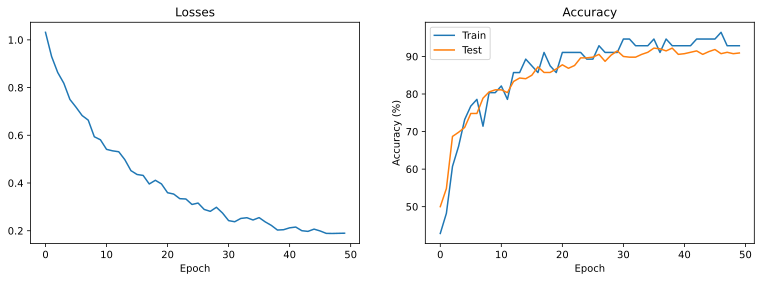

In [18]:
# show the results
fig, ax = plt.subplots(1, 2, figsize = (13, 4))

ax[0].plot(losses.detach())
ax[0].set_xlabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Losses")

ax[1].plot(trainAcc, label = "Train")
ax[1].plot(testAcc, label = "Test")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Accuracy")
ax[1].legend()
plt.show()

In [20]:
# before the experiment, configure and confirm the metaparameters

# specify the parameters for the model
nNodesInModel = 80
layersRange = [1, 5, 10, 20]
nDatapoints = np.arange(50, 551, 50)

# create a legend for later plotting
legend = []

# print out the model architectures
for lidx, layers in enumerate(layersRange):

    # create a model
    unitsperlayer = int(nNodesInModel/layersRange[lidx])
    net = createTheQwertyNet(unitsperlayer, layers)[0]

    # count it's parameters
    nparams = np.sum([p.numel() for p in net.parameters() if p.requires_grad])

    legend.append("%s layers, %s units, %s params" %(layers, unitsperlayer, nparams))
    print("This model will have %s layers, each with %s units, totalling %s parameters" %(layers, unitsperlayer, nparams))

This model will have 1 layers, each with 80 units, totalling 6963 parameters
This model will have 5 layers, each with 16 units, totalling 1459 parameters
This model will have 10 layers, each with 8 units, totalling 771 parameters
This model will have 20 layers, each with 4 units, totalling 427 parameters


In [23]:
# initialize results matrix
results = np.zeros((len(nDatapoints), len(layersRange), 2))

for didx, pnts in enumerate(nDatapoints):

    # create data
    theData = createSomeData(pnts)
    train_data = theData["train_data"]
    test_data = theData["test_data"]

    # now loop over layers
    for lidx, layers in enumerate(layersRange):

        unitsperlayer = int(nNodesInModel/layersRange[lidx])
        trainAcc, testAcc, losses, net = trainTheModel(unitsperlayer, layers)

        # avg of last 5 acccuracies and losses
        results[didx, lidx, 0] = np.mean(testAcc[-5:])
        results[didx, lidx, 1] = torch.mean(losses[-5:]).item()

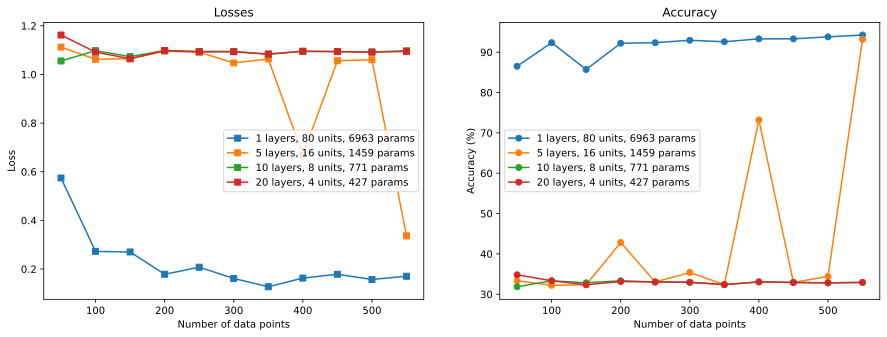

In [25]:
# show the results

fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(nDatapoints, results[:, :, 1], "s-")
ax[0].set_xlabel("Number of data points")
ax[0].set_ylabel("Loss")
ax[0].legend(legend)
ax[0].set_title("Losses")

ax[1].plot(nDatapoints, results[:, :, 0], "o-")
ax[1].set_xlabel("Number of data points")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Accuracy")
ax[1].legend(legend)
plt.show()